First off install dependencies. This assumes that the notebook is run in the correct virtualenv.

In [ ]:
!pip install pandas numpy seaborn gpy sklearn plotly

## Rename & Repackage Data
The data was in a format I did not prefer so it is renamed and repackaged here. This has to be done in several steps, else there is a memory error.

In [8]:
import pandas as pd
from math import radians, sin, cos

train_path = '../data/train3.pkl'
test_path = '../data/test3.pkl'

def equirectangular_projection(data):
    phi = data.lat.apply(radians)
    lamb = data.lon.apply(radians)
    lamb0 = lamb.mean()
    phi0 = phi.mean()
    r = 6378000  # earth radius in m
    x = r*(phi-phi0)
    y = r*(lamb - lamb0)*cos(phi0)
    return x, y

def compute_velocity(row):
    
    r = row.speed
    theta = radians(row.direction)
    row['dx'] = r*cos(radians(theta))
    row['dy'] = r*sin(radians(theta))
    return row

def filter_position_observed_events(data):
    return data[data.event == 'ObservedPositionEvent']

def repackage(from_path, to_path):
    data = pd.read_pickle(from_path)
    
    # Remove unnecessary fields
    del data['vehicle_id']
    del data['line']
    del data['station']
        
    data = filter_position_observed_events(data)
    
    del data['event']
    
    data.timestamp = data.timestamp.apply(pd.to_datetime)
    data = data.rename(columns = {
        'latitude': 'lat',
        'longitude': 'lon',
        'journey_number': 'traj',
        'segment_number': 'seg', 
        'speed': 'speed',
        'event': 'event',
        'timestamp': 'timestamp'
    })
    
    x, y = equirectangular_projection(data)
    data['x'] = x
    data['y'] = y
    
    del data['lat']
    del data['lon']

    data = data.apply(compute_velocity, axis=1)
    
    del data['direction']
    del data['speed']
    
    data.to_pickle(to_path)
    
repackage('../data/203_train.p', train_path)
repackage('../data/203_test.p', test_path)

KeyboardInterrupt: 

In [14]:
#data = pd.read_pickle('../data/train3.pkl')
#data.head()
def mean_timestamp(timestamps):    
    return pd.to_datetime(timestamps.values.astype(np.int64).mean())

X = data.iloc[0].copy()
data.iloc[4].timestamp = 6
X.timestamp = mean_timestamp(data.iloc[:10].timestamp)
compressed_data = data.drop(['timestamp', 'event', 'seg', 'station', 'line', 'traj'], axis=1).apply(np.mean, axis=0)
compressed_data['timestamp'] = mean_timestamp(data.iloc[:10].timestamp)# pd.Timestamp(2017, 1, 1, 12)
#compressed_data.timestamp = mean_timestamp(data.iloc[:10].timestamp)
compressed_data

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2018-02-16 03:48:40
2018-02-16 03:48:42.800000


Unnamed: 0                485.027
vehicle_id                5451.22
lon                       58.4093
lat                       15.5723
direction                  123.11
speed                      5.1206
timestamp     1518752922800000000
dtype: object

## Load training data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from IPython.display import display, clear_output
from model import learn_trajectory_model, plot_function, gamma_prior, FunctionModelPriors, TrajectoryModel, predict
from pandas import DataFrame

np.random.seed(1)
trajs_pickle_path = '../data/train3.pkl'
data = pd.read_pickle(trajs_pickle_path)
n_trajs = list(data.traj.unique())
n_trajs_to_use = 50 #len(n_trajs)
trajs_to_use = frozenset(np.random.choice(n_trajs, size=n_trajs_to_use, replace=False))
trajs = data[data.traj.transform(lambda j: j in trajs_to_use)]
traj_ns = trajs.traj.unique()
def load_seg(traj_n, seg_n):
    return trajs[(trajs.traj == traj_n) & (trajs.seg == seg_n)]

## Learn normalisation functions for each segment
All trajectories must be in the same space, so normalisation is done segement-wise. This will not be Euclidian, so ARD need to be used.

In [3]:
from math import sqrt
seg_dict = dict(tuple(data.groupby('seg')))
def normalisation(seg: DataFrame):
    dx = seg.x.mean()
    dy = seg.y.mean()
    sd  = sqrt(max(seg.x.var(), seg.y.var()))
    def do_normalisation(data):
        data2 = data.copy()
        data2.x = (data.x - dx)/sd
        data2.y = (data.y - dy)/sd
        return data2
    
    return {
        'scale': do_normalisation,
        'sd': sd,
        'dx': dx,
        'dy': dy
    }
seg_norms = {
    seg_n: normalisation(seg_dict[seg_n])
    for seg_n in seg_dict
}

def normaliser_for_seg(seg_n: int):
    return seg_norms[seg_n] 

## Pre processing logic

In [4]:
from numpy import ndarray
import math
from model import stop_compress

def drop_start_dwell(data: DataFrame):
    # https://stackoverflow.com/questions/52907328/pandas-delete-first-n-rows-until-condition-on-columns-is-fulfilled
    return data.loc[((data.dx > 0) & (data.dy > 0)).idxmax():]
    
    
def take_fraction(data, r):
    return data[data.tau <= r]
    #n = int(np.round(r*data.shape[0]))
    #return data.iloc[:n]


def compute_tau(data: DataFrame) -> ndarray:
    return np.linspace(0, 1, data.shape[0])


def compute_time_left(data: DataFrame) -> DataFrame:
    sorted_data = data.sort_values('timestamp')
    arrival_time = sorted_data.iloc[-1].timestamp
    sorted_data['time_left'] = [
        (arrival_time - t).seconds
        for t in sorted_data.timestamp
    ]
    return sorted_data
    
    
def compute_velocity_from_pos(data: DataFrame):
    """Assume one data point per second."""
    def velocity(cur, nxt):
        #dt = nxt.timestamp.second - cur.timestamp.second
        dxx = float(nxt.x - cur.x) #/ dt
        dyy = float(nxt.y - cur.y) #/ dt
       # print(nxt.y, cur.y)
        return dxx, dyy #if dt > 0 else None

    dx = []
    dy = []
    for n in range(0, data.shape[0]-1):
        cur = data.iloc[n]
        nxt = data.iloc[n+1]
        dv = velocity(cur, nxt)
        
        # If two observations are sent the same 
        # seconds, everything breaks
        #if dv is None:
        #    nxt2 = data.iloc[n+2]
        #    dv = velocity(cur, nxt2)
        

        dx.append(dv[0])
        dy.append(dv[1])
            
    dx.append(dx[-1])
    dy.append(dy[-1])
    return dx, dy


def pre_process(data: DataFrame, stop_compress_delta: float, fraction_observed: float = 1) -> DataFrame:
    data = compute_time_left(data)
    data = stop_compress(data, stop_compress_delta)
    data['tau'] = compute_tau(data)
    data = take_fraction(data, fraction_observed) 
    normaliser = normaliser_for_seg(data.iloc[0].seg)
    data = normaliser['scale'](data)
    dx, dy = compute_velocity_from_pos(data)
    data['dx'] = dx
    data['dy'] = dy
    return data

## Learn a model
Problem with velocity log likelihood becoming inf for fixed noise 0.004, but solved for 0.04. However, this gives all models a high likelihood, and shit performance.

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -517.9912715630625
Optimization restart 2/3, f = -517.991271563736


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/3, f = -517.9912715016408
Optimization restart 1/3, f = -687.8894882120792
Optimization restart 2/3, f = -687.8894882083465
Optimization restart 3/3, f = -687.8894882121746
Optimization restart 1/3, f = -598.3888029639154
Optimization restart 2/3, f = -598.3888029704544
Optimization restart 3/3, f = -598.3888029745508
Optimization restart 1/3, f = -714.741189546368
Optimization restart 2/3, f = -714.7411895449968
Optimization restart 3/3, f = -714.7411895464257


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\pandas\core\frame.py:6211: FutureWarning:Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Optimization restart 1/3, f = -3791.1309853279918
Optimization restart 2/3, f = -3788.550766685746
Optimization restart 3/3, f = -3791.1309851721135
Optimization restart 1/3, f = 383.49400104979793
Optimization restart 2/3, f = 383.49503052855493
Optimization restart 3/3, f = 383.5185466537077


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


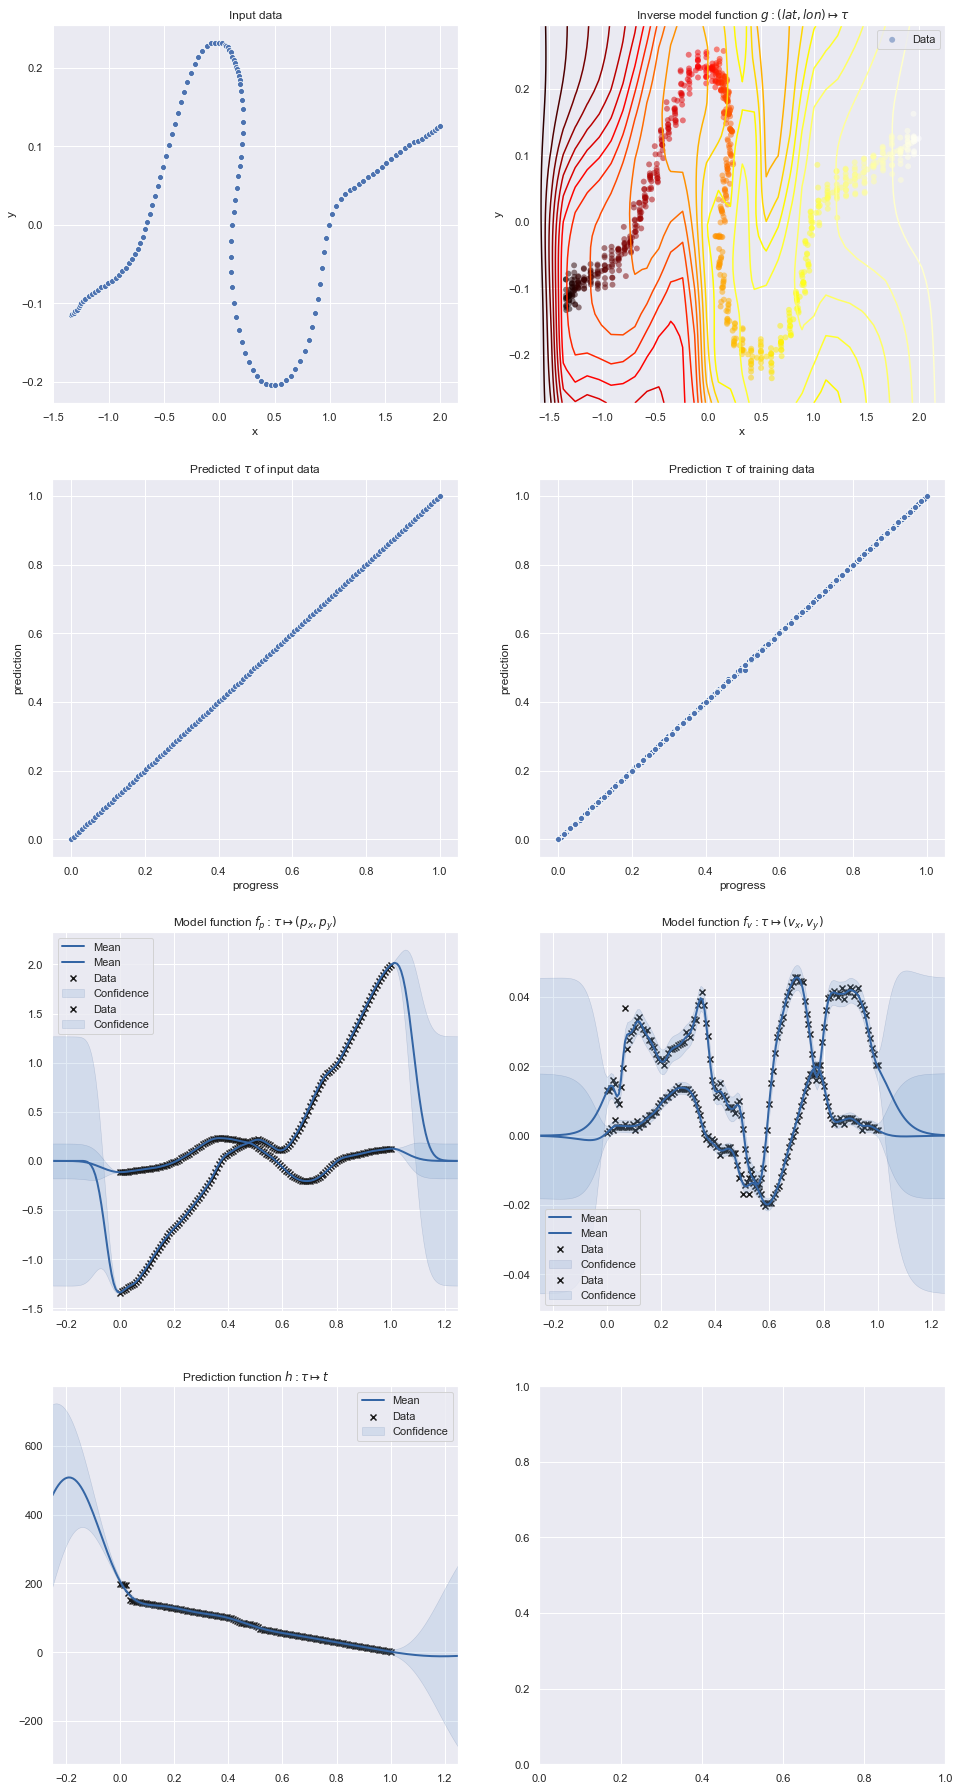

In [5]:
from math import sqrt, cos, sin, radians
from plotting import plot_grid
import seaborn as sns
import GPy
from GPy.models import GPRegression
from typing import List
from model import FunctionModel

%matplotlib inline
sns.set(style="darkgrid")

def learn_function(
    X: ndarray, Y: ndarray, applyPriors,
    f_type: str, route: int, segment: int, kernel=None,
    n_restarts=3
) -> FunctionModel:
    #print(kernel)
    model = GPRegression(
        X, Y, kernel, 
        normalizer=False
    )
    applyPriors(model)    
    #print(model)
    model.optimize_restarts(n_restarts)
    return FunctionModel(
        f_type, model
    )

def create_support_data(
    pos: ndarray,
    tau: ndarray,
    f_p_x, f_p_y, f_v_x, f_v_y, 
    n_samples: int,
    delta: float,
    sigma: float) -> DataFrame:

    def orth_comp(v):
        return np.array([-v[1], v[0]])

    tau_grid = np.linspace(
        np.min(np.min(tau)),
        np.min(np.max(tau)),
        1/delta
    )
    
    tau = tau_grid.reshape(len(tau_grid), 1)
    x, _ = predict(f_p_x, tau)
    y, _ = predict(f_p_y, tau)
    dx, _ = predict(f_v_x, tau)
    dy, _ = predict(f_v_y, tau)
    acc = []
    pos = np.hstack([x, y])
    vel = np.hstack([dx, dy])
    for n in range(len(tau_grid)-1):
        cur_vel = vel[n]
        cur_pos = pos[n]
        nxt_pos = pos[n+1]
        orth_delta = orth_comp(nxt_pos - cur_pos)
        orth_delta = orth_delta / np.linalg.norm(orth_delta)
        
        acc.extend([
            {'x': x[0],
             'y': x[1],
             #'dx': cur_vel[0],
             #'dy': cur_vel[1],
             'tau': tau_grid[n]}
            for x in [
                cur_pos + orth_delta * x
                for x in np.random.normal(0, sigma, n_samples)
            ]
        ])

    return pd.DataFrame(acc)

def learn_model(
    data: DataFrame, route_n: int, seg_n: int, 
    f_p_codomain, f_v_codomain,
    f_p_likelihood_noise, 
    f_v_likelihood_noise) -> TrajectoryModel:
    
    tau = data['tau'].values.reshape(-1, 1)
    normaliser = normaliser_for_seg(seg_n)
    def apply_f_p_x_priors(m):
        # kern.rbf.lengthscale
        m.kern.lengthscale.set_prior(gamma_prior(0.15, 0.1))
        m.kern.variance.set_prior(gamma_prior(0.25, 0.1))
        #m.kern.linear.variances.set_prior(gamma_prior(0.15, 0.1))
        return
        m.likelihood.variance = f_p_likelihood_noise / normaliser['sd']
        m.likelihood.variance.fix()
        
    def apply_f_p_y_priors(m):
        m.kern.lengthscale.set_prior(gamma_prior(0.15, 0.1))
        m.kern.variance.set_prior(gamma_prior(0.25, 0.1))
        #m.kern.linear.variances.set_prior(gamma_prior(0.15, 0.1))
        return
        m.likelihood.variance = f_p_likelihood_noise / normaliser['sd']
        m.likelihood.variance.fix()
    
    def apply_f_v_x_priors(m):
        #m.kern.lengthscale.set_prior(gamma_prior(0.1, 0.04))
        #m.kern.variance.set_prior(gamma_prior(75, 5))
        #m.likelihood_noise.set_prior(gamma_prior(0.4, 0.4))
        return
        m.likelihood.variance = f_v_likelihood_noise / normaliser['sd']
        m.likelihood.variance.fix()
        
    def apply_f_v_y_priors(m):
        #m.kern.lengthscale.set_prior(gamma_prior(0.1, 0.04))
        #m.kern.variance.set_prior(gamma_prior(75, 5))
        #m.likelihood_noise.set_prior(gamma_prior(0.4, 0.4))
        return
        m.likelihood.variance = f_v_likelihood_noise / normaliser['sd']
        m.likelihood.variance.fix()
        
    def apply_g_priors(m):
        return
        #m.kern.rbf.lengthscale.set_prior(gamma_prior(0.10, 0.05))
        #m.kern.rbf.variance.set_prior(gamma_prior(0.25, 0.1))
        #m.kern.linear.variances.set_prior(gamma_prior(0.15, 0.1))
        #m.likelihood.variance = 0.1
        #m.likelihood.variance.fix()
             
    def apply_h_priors(m):
        m.likelihood.variance = 10
        m.likelihood.variance.fix()
    
    f_p_x = learn_function(
        tau, data['x'].values.reshape(-1, 1),
        apply_f_p_x_priors, 'f_p_x',
        route_n, seg_n, kernel=GPy.kern.RBF(
            input_dim=1,
            ARD=False
        )
    )
    
    f_p_y = learn_function(
        tau, data['y'].values.reshape(-1, 1),
        apply_f_p_y_priors, 'f_p_y', 
        route_n, seg_n, kernel=GPy.kern.RBF(
            input_dim=1,
            ARD=False
        ) 
    )
    
    f_v_x = learn_function(
        tau, data['dx'].values.reshape(-1, 1),
        apply_f_v_x_priors, 'f_v_x',
        route_n, seg_n, kernel=GPy.kern.Matern52(
            input_dim=1,
            ARD=False
        )
    )

    f_v_y = learn_function(
        tau, data['dy'].values.reshape(-1, 1), 
        apply_f_v_y_priors, 'f_v_y', 
        route_n, seg_n, kernel=GPy.kern.Matern52(
            input_dim=1,
            ARD=False
        )
    )
 
    n_augment_samples = 10
    augment_sigma = 8 / normaliser['sd']# meters
    augment_delta = 0.015
    support_data = create_support_data(
        data[['x', 'y']].values.reshape(-1, 1), 
        tau, f_p_x, f_p_y, f_v_x, f_v_y, 
        n_augment_samples,
        augment_delta, augment_sigma
    )
    augmented_data = \
        data[['x', 'y', 'tau']] \
        .append(support_data)
    
    g_pos = augmented_data[['x', 'y']].values.reshape(-1, 2)
    g_tau = augmented_data['tau'].values.reshape(-1, 1)
    
    g = learn_function(
        g_pos, g_tau,
        apply_g_priors, 'g', 
        route_n, seg_n, kernel=GPy.kern.RBF(
            input_dim=2,
            ARD=False
        ) + GPy.kern.Linear(
            input_dim=2,
            ARD=False
        )   
    )
    
    time_left = data['time_left'].values.reshape(-1, 1)
    h = learn_function(
        tau, time_left,
        apply_h_priors, 'h', 
        route_n, seg_n, kernel=GPy.kern.RBF(
            input_dim=1,
            ARD=False
        ) + GPy.kern.Linear(
            input_dim=1,
            ARD=False
        )   
    )
    return TrajectoryModel(
        route_n, seg_n, f_p_x, f_p_y, f_v_x, f_v_y, g, h
    )

def plot_model(m: TrajectoryModel, data: DataFrame, f_p_codomain, f_v_codomain):
    n_rows = 4
    n_cols = 2
    fig_size = 8
    _, axs = plot_grid(n_rows, n_cols)

    # Input data
    sns.scatterplot(
        data=data, 
        x=f_p_codomain[0], 
        y=f_p_codomain[1], 
        ax=axs[0][0]
    )
    axs[0][0].set_title('Input data')

    # h for input data
    x = data[f_p_codomain].values
    mean, _  = predict(m.g, x)
    df = pd.DataFrame({
        'prediction': mean.T[0], 
        'progress': data['tau'].values
    })
    sns.scatterplot(
        data=df, 
        x='progress', 
        y='prediction', 
        ax=axs[1][0]
    )
    axs[1][0].set_title(r'Predicted $\tau$ of input data')
    #axs[1][0].set_aspect('equal', 'datalim')

    # Training data
    plot_function(m.g, ax=axs[0][1])
    axs[0][1].set_title(r'Inverse model function $g: (lat,lon) \mapsto \tau$')
    axs[0][1].set_xlabel('x')
    axs[0][1].set_ylabel('y')
    #axs[0][1].axis('scaled')
    
    # H for training data
    mean, _  = m.g.model.predict(m.g.model.X)
    df = pd.DataFrame({
        'prediction': mean.T[0], 
        'progress': m.g.model.Y.flatten()
    })
    sns.scatterplot(
        data=df, 
        x='progress', 
        y='prediction', 
        ax=axs[1][1]
    )
    axs[1][1].set_title(r'Prediction $\tau$ of training data')

    # f_p
    plot_function(m.f_p_x, ax=axs[2][0])
    plot_function(m.f_p_y, ax=axs[2][0])
    axs[2][0].set_title(r'Model function $f_p: \tau \mapsto (p_x, p_y)$')

    
    # f_v
    plot_function(m.f_v_x, ax=axs[2][1])
    plot_function(m.f_v_y, ax=axs[2][1])
    axs[2][1].set_title(r'Model function $f_v: \tau \mapsto (v_x, v_y)$')

    # h
    plot_function(m.h, ax=axs[3][0])
    axs[3][0].set_title(r'Prediction function $h: \tau \mapsto t$')

np.random.seed(1)
route_n = 3
seg_n = 9
train_traj_ix = 0
traj_n = traj_ns[train_traj_ix]
stop_compress_delta = 4  # meters   
f_p_likelihood_noise = 1 # meters  
f_v_likelihood_noise = 0.002  #0.004 # meters?  
seg = pre_process(
    load_seg(traj_n, seg_n),
    stop_compress_delta
)

f_p_codomain = ['x', 'y']
f_v_codomain = ['dx', 'dy']
m = learn_model(
    seg, route_n, seg_n, 
    f_p_codomain, f_v_codomain,
    f_p_likelihood_noise,
    f_v_likelihood_noise
)
plot_model(
    m, seg, 
    f_p_codomain, 
    f_v_codomain
)

## Learn many models

In [152]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from model import FunctionModelPriors, learn_trajectory_model, save_model, acquire_db_conn#plot_function, gamma_prior, , predict
from functools import reduce

np.random.seed(1)

def learn(traj_n, seg_n):
    seg = pre_process(load_seg(traj_n, seg_n), stop_compress_delta)
    return learn_model(
        seg, route_n, seg_n, 
        f_p_codomain, f_v_codomain,
        f_p_likelihood_noise, 
        f_v_likelihood_noise
    )

models = [
    learn(traj_n, seg_n) 
    for traj_n in traj_ns
]

with acquire_db_conn() as conn:
    for m in models:
        m_id = save_model(m, conn)

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -517.9912715621575
Optimization restart 2/3, f = -517.9912715602488
Optimization restart 3/3, f = -517.9912715015957


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -687.8894882122369
Optimization restart 2/3, f = -687.8894882083857
Optimization restart 3/3, f = -687.8894882121672
Optimization restart 1/3, f = -598.3888029639145
Optimization restart 2/3, f = -598.3888029704548
Optimization restart 3/3, f = -598.3888029745522
Optimization restart 1/3, f = -714.7411895463704
Optimization restart 2/3, f = -714.7411895449407
Optimization restart 3/3, f = -714.7411895464417


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\pandas\core\frame.py:6211: FutureWarning:Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Optimization restart 1/3, f = -3791.1310603956445
Optimization restart 2/3, f = -3788.550814971532
Optimization restart 3/3, f = -3791.1310603522656
Optimization restart 1/3, f = 383.49400104980117
Optimization restart 2/3, f = 383.49503052853026
Optimization restart 3/3, f = 383.5185466536954


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -635.3800712749523
Optimization restart 2/3, f = -635.38007125464
Optimization restart 3/3, f = -635.3800712700254


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -727.5349290267875
Optimization restart 2/3, f = -732.9804334951269
Optimization restart 3/3, f = -732.9804334969747
Optimization restart 1/3, f = -684.2108399331087
Optimization restart 2/3, f = -684.210839933035
Optimization restart 3/3, f = -684.2108399330995
Optimization restart 1/3, f = -777.9278301053781
Optimization restart 2/3, f = -777.9278301053679
Optimization restart 3/3, f = -777.9278301053379
Optimization restart 1/3, f = -4346.861724226551
Optimization restart 2/3, f = -4343.561148077859
Optimization restart 3/3, f = -4343.5611481789165
Optimization restart 1/3, f = 342.0064729817607
Optimization restart 2/3, f = 342.0085123196724
Optimization restart 3/3, f = 342.0064729818397


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -487.9261457652573
Optimization restart 2/3, f = -487.92614576578865
Optimization restart 3/3, f = -487.92614576746


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -609.913144107574
Optimization restart 2/3, f = -404.6512375793458
Optimization restart 3/3, f = -609.9131441083595
Optimization restart 1/3, f = -551.3513709676076
Optimization restart 2/3, f = -551.3513709925653
Optimization restart 3/3, f = -551.3513709918766
Optimization restart 1/3, f = -650.7883871735762
Optimization restart 2/3, f = -650.7883871738524
Optimization restart 3/3, f = -650.7883871737844
Optimization restart 1/3, f = -4092.4663465100675
Optimization restart 2/3, f = -4092.466347979489
Optimization restart 3/3, f = -4092.466351364188
Optimization restart 1/3, f = 360.53934635391767
Optimization restart 2/3, f = 360.53934635381165
Optimization restart 3/3, f = 360.5393463538104


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -452.5017617907298
Optimization restart 2/3, f = -452.50176179260757
Optimization restart 3/3, f = -452.50176179087697


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -541.6423276884402
Optimization restart 2/3, f = -541.6423276881317
Optimization restart 3/3, f = -541.6423275233628
Optimization restart 1/3, f = -504.5243882252619
Optimization restart 2/3, f = -504.5243882256034
Optimization restart 3/3, f = -504.52438822546264
Optimization restart 1/3, f = -570.1720885988897
Optimization restart 2/3, f = -570.1720885987892
Optimization restart 3/3, f = -570.1720885968904
Optimization restart 1/3, f = -3842.6311083646
Optimization restart 2/3, f = -3842.6310713393864
Optimization restart 3/3, f = -3842.6311083326877
Optimization restart 1/3, f = 296.2095805510958
Optimization restart 2/3, f = 296.2710701938125
Optimization restart 3/3, f = 296.22444824957245


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -508.30901988628557
Optimization restart 2/3, f = -508.30901983793194
Optimization restart 3/3, f = -508.30901986886107


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -595.8387356453935
Optimization restart 2/3, f = -595.8387356450286
Optimization restart 3/3, f = -595.8387356386394
Optimization restart 1/3, f = -564.3146108392249
Optimization restart 2/3, f = -564.3146108568777
Optimization restart 3/3, f = -564.3146108111706
Optimization restart 1/3, f = -632.0327317998976
Optimization restart 2/3, f = -632.0327318026904
Optimization restart 3/3, f = -632.0327318030847
Optimization restart 1/3, f = -4419.0225807600145
Optimization restart 2/3, f = -4548.5571140751135
Optimization restart 3/3, f = -4548.557107883176
Optimization restart 1/3, f = 325.4885673200176
Optimization restart 2/3, f = 325.48856732013684
Optimization restart 3/3, f = 325.4885673200771


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -426.1119594238734
Optimization restart 2/3, f = -426.1119594365195
Optimization restart 3/3, f = -426.1119594370108


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -550.9621631911533


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\paramz\transformations.py:119: RuntimeWarning:overflow encountered in expm1
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\paramz\transformations.py:121: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/3, f = -550.962163191566
Optimization restart 3/3, f = -550.9621631916339
Optimization restart 1/3, f = -494.38754082811414
Optimization restart 2/3, f = -494.38754082242144
Optimization restart 3/3, f = -494.3875408289207
Optimization restart 1/3, f = -580.7773219723963
Optimization restart 2/3, f = -580.7773219985548
Optimization restart 3/3, f = -580.7773219999632
Optimization restart 1/3, f = -3918.7202293321025
Optimization restart 2/3, f = -3918.7202296090445
Optimization restart 3/3, f = -3918.720229633471
Optimization restart 1/3, f = 267.68701536657477
Optimization restart 2/3, f = 267.68701536657346
Optimization restart 3/3, f = 267.58993302895044


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -516.9713290831123
Optimization restart 2/3, f = -516.9713290805836
Optimization restart 3/3, f = -516.9713290825971


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -663.2664820362471
Optimization restart 2/3, f = -663.2664820361222
Optimization restart 3/3, f = -663.2664820355925
Optimization restart 1/3, f = -573.7451562069793
Optimization restart 2/3, f = -573.7451562064172
Optimization restart 3/3, f = -573.7451562071036
Optimization restart 1/3, f = -695.3549728870524
Optimization restart 2/3, f = -695.3549728870482
Optimization restart 3/3, f = -695.3549728725716
Optimization restart 1/3, f = -4110.498808934066
Optimization restart 2/3, f = -4110.500701006889
Optimization restart 3/3, f = -4110.500701031808
Optimization restart 1/3, f = 367.8043867004467
Optimization restart 2/3, f = 367.8043867004432
Optimization restart 3/3, f = 367.81185161305075


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -504.1710212926623
Optimization restart 2/3, f = -497.8827673271853
Optimization restart 3/3, f = -504.1710212960408


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -565.4559828357927
Optimization restart 2/3, f = -565.4559829364333
Optimization restart 3/3, f = -565.4559829365982
Optimization restart 1/3, f = -584.3383964449416
Optimization restart 2/3, f = -584.3383964359119
Optimization restart 3/3, f = -584.338396444915
Optimization restart 1/3, f = -602.1724990444997
Optimization restart 2/3, f = -602.1724990445347
Optimization restart 3/3, f = -602.1724990115159
Optimization restart 1/3, f = -4176.316907792693
Optimization restart 2/3, f = -4176.316906415487
Optimization restart 3/3, f = -4176.316908500554
Optimization restart 1/3, f = 399.6790321710186
Optimization restart 2/3, f = 399.67903219635355
Optimization restart 3/3, f = 399.65857485747637


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -522.761189815002
Optimization restart 2/3, f = -522.7611898056813
Optimization restart 3/3, f = -522.7611898105532


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -652.8112684549296
Optimization restart 2/3, f = -652.8112684315154
Optimization restart 3/3, f = -652.8112684542799
Optimization restart 1/3, f = -582.1999129505136
Optimization restart 2/3, f = -515.4378478237325
Optimization restart 3/3, f = -582.1999129489504
Optimization restart 1/3, f = -684.3325051293261
Optimization restart 2/3, f = -684.3325051477839
Optimization restart 3/3, f = -684.3325051451125
Optimization restart 1/3, f = -4321.019757017242
Optimization restart 2/3, f = -4321.019756774624
Optimization restart 3/3, f = -4321.019756884191
Optimization restart 1/3, f = 360.7692756363324
Optimization restart 2/3, f = 360.7692756356353
Optimization restart 3/3, f = 360.76927563597735


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -535.740351989294
Optimization restart 2/3, f = -535.7403519891835
Optimization restart 3/3, f = -535.740351962808


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -655.5865259250791
Optimization restart 2/3, f = -655.5865259257665
Optimization restart 3/3, f = -655.5865259256963
Optimization restart 1/3, f = -604.8877263310712
Optimization restart 2/3, f = -604.8877263314496
Optimization restart 3/3, f = -604.8877263314496
Optimization restart 1/3, f = -689.6620126560265
Optimization restart 2/3, f = -689.6620126558172
Optimization restart 3/3, f = -689.6620126556079
Optimization restart 1/3, f = -4024.8758256436995
Optimization restart 2/3, f = -4080.230671837491
Optimization restart 3/3, f = -4080.230671809323
Optimization restart 1/3, f = 360.09958618371445
Optimization restart 2/3, f = 360.11240089594105
Optimization restart 3/3, f = 360.0995861756964


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -543.8803468242467
Optimization restart 2/3, f = -543.8803468229685
Optimization restart 3/3, f = -543.8803468253957


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -609.5174002062753
Optimization restart 2/3, f = -609.5174002019146
Optimization restart 3/3, f = -609.5174002057815
Optimization restart 1/3, f = -601.2902766260552
Optimization restart 2/3, f = -601.290276626271
Optimization restart 3/3, f = -601.2902763671852
Optimization restart 1/3, f = -640.5505498996487
Optimization restart 2/3, f = -640.550549960521
Optimization restart 3/3, f = -640.5505499605382
Optimization restart 1/3, f = -3914.979483353285
Optimization restart 2/3, f = -4178.695542338406
Optimization restart 3/3, f = -4095.508936865267
Optimization restart 1/3, f = 423.05760152674475
Optimization restart 2/3, f = 423.03530425023496
Optimization restart 3/3, f = 423.0448821589356


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -475.51141013360206
Optimization restart 2/3, f = -475.5114101350285
Optimization restart 3/3, f = -475.51141013876077


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -585.9196429856125
Optimization restart 2/3, f = -585.9196429821942
Optimization restart 3/3, f = -585.9196429857622
Optimization restart 1/3, f = -538.7505315780709
Optimization restart 2/3, f = -538.7505315780485
Optimization restart 3/3, f = -538.7505315779957
Optimization restart 1/3, f = -620.479158959736
Optimization restart 2/3, f = -620.4791589294488
Optimization restart 3/3, f = -620.4791589597444
Optimization restart 1/3, f = -3984.0571186466186
Optimization restart 2/3, f = -3984.057118707835
Optimization restart 3/3, f = -3984.0571187595033
Optimization restart 1/3, f = 343.4175774576158
Optimization restart 2/3, f = 343.4330619311296
Optimization restart 3/3, f = 343.41757745756115


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -541.3535701211797
Optimization restart 2/3, f = -541.3535701194563
Optimization restart 3/3, f = -541.3535700116082


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -647.6752466624224
Optimization restart 2/3, f = -647.6752467505762
Optimization restart 3/3, f = -647.6752467516504
Optimization restart 1/3, f = -608.990988295792
Optimization restart 2/3, f = -608.9909882859848
Optimization restart 3/3, f = -608.9909882958424
Optimization restart 1/3, f = -694.9553486916263
Optimization restart 2/3, f = -694.9553486916434
Optimization restart 3/3, f = -694.955348691035
Optimization restart 1/3, f = -4394.792252934822
Optimization restart 2/3, f = -4394.792253028118
Optimization restart 3/3, f = -3918.100664191432
Optimization restart 1/3, f = 329.47324682960544
Optimization restart 2/3, f = 322.4614910015823
Optimization restart 3/3, f = 322.45474060608393


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -639.3259374236147
Optimization restart 2/3, f = -639.3259374097407
Optimization restart 3/3, f = -639.3259374135571


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -743.2518913599923
Optimization restart 2/3, f = -743.2518913593453
Optimization restart 3/3, f = -743.2518913600227
Optimization restart 1/3, f = -722.0635906959951
Optimization restart 2/3, f = -722.063590698607
Optimization restart 3/3, f = -722.0635907043404
Optimization restart 1/3, f = -787.6730872702645
Optimization restart 2/3, f = -787.673087272231
Optimization restart 3/3, f = -787.673087273211
Optimization restart 1/3, f = -5007.64827291873
Optimization restart 2/3, f = -5033.7659229811625
Optimization restart 3/3, f = -5033.76592163913
Optimization restart 1/3, f = 306.4741952105473
Optimization restart 2/3, f = 306.47419521233945
Optimization restart 3/3, f = 306.4741952107732


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -516.9805151054277
Optimization restart 2/3, f = -516.9805150720781
Optimization restart 3/3, f = -516.9805152130281


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -581.5874861620723
Optimization restart 2/3, f = -581.5874863698564
Optimization restart 3/3, f = -581.5874863699387
Optimization restart 1/3, f = -563.6771592397148
Optimization restart 2/3, f = -563.6771592415942
Optimization restart 3/3, f = -563.6771592415994
Optimization restart 1/3, f = -621.726883124409
Optimization restart 2/3, f = -621.72688312434
Optimization restart 3/3, f = -621.7268831243908
Optimization restart 1/3, f = -4155.597586911548
Optimization restart 2/3, f = -4155.597586880309
Optimization restart 3/3, f = -3508.3139848569876
Optimization restart 1/3, f = 354.2372721399795
Optimization restart 2/3, f = 354.06256641734996
Optimization restart 3/3, f = 354.2847050897065


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -415.3924037267543
Optimization restart 2/3, f = -415.3924037269062
Optimization restart 3/3, f = -415.39240372702966


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -603.9582684208909
Optimization restart 2/3, f = -603.9582683919716
Optimization restart 3/3, f = -603.9582684207566
Optimization restart 1/3, f = -462.9970289453094
Optimization restart 2/3, f = -462.9970289455787
Optimization restart 3/3, f = -462.9970289454503
Optimization restart 1/3, f = -626.401148534726
Optimization restart 2/3, f = -626.4011485347585
Optimization restart 3/3, f = -626.4011485341939
Optimization restart 1/3, f = -4110.704732543793
Optimization restart 2/3, f = -4110.704745545965
Optimization restart 3/3, f = -4110.704745807254
Optimization restart 1/3, f = 350.3095937675287
Optimization restart 2/3, f = 348.89271240226066
Optimization restart 3/3, f = 348.9352835025082


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -608.1454430255106
Optimization restart 2/3, f = -608.1454430827339
Optimization restart 3/3, f = -608.1454430796924


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -660.7191958973725
Optimization restart 2/3, f = -660.719195897561
Optimization restart 3/3, f = -660.7191958958582
Optimization restart 1/3, f = -687.0584965025395
Optimization restart 2/3, f = -687.0584965021562
Optimization restart 3/3, f = -687.0584964998694
Optimization restart 1/3, f = -713.1854162972529
Optimization restart 2/3, f = -713.1854162780697
Optimization restart 3/3, f = -713.1854163036312
Optimization restart 1/3, f = -4578.111237773303
Optimization restart 2/3, f = -4353.128699650006
Optimization restart 3/3, f = -4578.111211464809
Optimization restart 1/3, f = 345.2068280219467
Optimization restart 2/3, f = 345.20682802196495
Optimization restart 3/3, f = 345.2085276711666


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -506.9936172486096
Optimization restart 2/3, f = -506.9936172502947
Optimization restart 3/3, f = -488.4063616223725


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -582.574487791388
Optimization restart 2/3, f = -582.5744877852775
Optimization restart 3/3, f = -582.5744877922573
Optimization restart 1/3, f = -567.8703025526179
Optimization restart 2/3, f = -567.8703025526402
Optimization restart 3/3, f = -567.8703025516033
Optimization restart 1/3, f = -612.5783750123124
Optimization restart 2/3, f = -612.5783750140146
Optimization restart 3/3, f = -612.578375013868
Optimization restart 1/3, f = -3835.970296654129
Optimization restart 2/3, f = -3835.9702968177007
Optimization restart 3/3, f = -3835.9702967273274
Optimization restart 1/3, f = 319.0867667559568
Optimization restart 2/3, f = 319.08787854883536
Optimization restart 3/3, f = 320.2528985530665


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -504.52264765585494
Optimization restart 2/3, f = -504.52264765811424
Optimization restart 3/3, f = -504.52264765626467


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -608.7265179195014
Optimization restart 2/3, f = -608.7265179192619
Optimization restart 3/3, f = -608.7265179196029
Optimization restart 1/3, f = -567.1682002510468
Optimization restart 2/3, f = -567.168200250678
Optimization restart 3/3, f = -567.1682002507393
Optimization restart 1/3, f = -648.9389057057865
Optimization restart 2/3, f = -648.938905719422
Optimization restart 3/3, f = -648.9389056997593
Optimization restart 1/3, f = -4148.919383752429
Optimization restart 2/3, f = -4148.919383726396
Optimization restart 3/3, f = -4148.919383795103
Optimization restart 1/3, f = 325.19121706742766
Optimization restart 2/3, f = 325.21619472779275
Optimization restart 3/3, f = 325.36684123113895


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -391.1459321168134
Optimization restart 2/3, f = -391.1459321200383
Optimization restart 3/3, f = -391.1459321198144


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -489.7683642435307
Optimization restart 2/3, f = -489.7683642493897
Optimization restart 3/3, f = -489.76836424931196
Optimization restart 1/3, f = -426.4436702167138
Optimization restart 2/3, f = -426.4436701897901
Optimization restart 3/3, f = -426.4436702167182
Optimization restart 1/3, f = -517.8371813748115
Optimization restart 2/3, f = -517.8371813747609
Optimization restart 3/3, f = -517.8371813745298
Optimization restart 1/3, f = -3906.086284194174
Optimization restart 2/3, f = -3906.0862841904477
Optimization restart 3/3, f = -3906.086281913288
Optimization restart 1/3, f = 310.3397313538661


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 2/3, f = 310.3877951440185
Optimization restart 3/3, f = 308.60950240327634


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -485.5365334303715
Optimization restart 2/3, f = -478.58427078913877
Optimization restart 3/3, f = -485.5365334325114


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -586.8496876991006
Optimization restart 2/3, f = -586.8496876938563
Optimization restart 3/3, f = -586.8496877085959
Optimization restart 1/3, f = -533.0890208076536
Optimization restart 2/3, f = -533.0890208080551
Optimization restart 3/3, f = -533.0890208079129
Optimization restart 1/3, f = -596.1484064291482
Optimization restart 2/3, f = -596.1484064291557
Optimization restart 3/3, f = -596.1484064272198
Optimization restart 1/3, f = -4352.206324460766
Optimization restart 2/3, f = -4352.206325051711
Optimization restart 3/3, f = -4352.206324977262
Optimization restart 1/3, f = 330.1427875826038
Optimization restart 2/3, f = 332.2479984365094
Optimization restart 3/3, f = 332.1901769961229


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -528.7769578413931
Optimization restart 2/3, f = -528.7769578473376
Optimization restart 3/3, f = -528.7769578621458


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -590.2025812610564
Optimization restart 2/3, f = -590.2025812609666
Optimization restart 3/3, f = -590.202581231475
Optimization restart 1/3, f = -592.4708440131457
Optimization restart 2/3, f = -592.4708440112759
Optimization restart 3/3, f = -592.4708440131302
Optimization restart 1/3, f = -622.1332279782056
Optimization restart 2/3, f = -622.1332279859832
Optimization restart 3/3, f = -622.1332279859116
Optimization restart 1/3, f = -4552.937394035486
Optimization restart 2/3, f = -4563.057583679363
Optimization restart 3/3, f = -4563.05758317791
Optimization restart 1/3, f = 283.4272262584519
Optimization restart 2/3, f = 282.46190496881223
Optimization restart 3/3, f = 283.4170016090256


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -505.2506294736972
Optimization restart 2/3, f = -505.250629547061
Optimization restart 3/3, f = -505.2506295479211


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -572.59680646744
Optimization restart 2/3, f = -572.596806475431
Optimization restart 3/3, f = -572.5968064746206
Optimization restart 1/3, f = -579.8454632966476
Optimization restart 2/3, f = -579.8454644859166
Optimization restart 3/3, f = -563.1191033207907
Optimization restart 1/3, f = -613.428503216531
Optimization restart 2/3, f = -613.4285032165924
Optimization restart 3/3, f = -613.4285030794796
Optimization restart 1/3, f = -4573.935376876492
Optimization restart 2/3, f = -4573.935153416482
Optimization restart 3/3, f = -4573.935374496747
Optimization restart 1/3, f = 280.15696338206993
Optimization restart 2/3, f = 280.15696338207283
Optimization restart 3/3, f = 280.16903102439693


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -555.1910721040249
Optimization restart 2/3, f = -555.1910721110489
Optimization restart 3/3, f = -555.1910721102665


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -654.0972022796279
Optimization restart 2/3, f = -654.097202275944
Optimization restart 3/3, f = -654.0972022794801
Optimization restart 1/3, f = -624.3862462743639
Optimization restart 2/3, f = -624.3862462745014
Optimization restart 3/3, f = -624.3862462744096
Optimization restart 1/3, f = -710.5912345929343
Optimization restart 2/3, f = -710.5912345929344
Optimization restart 3/3, f = -710.5912345909892
Optimization restart 1/3, f = -4072.0514995722156
Optimization restart 2/3, f = -4072.0515283153172
Optimization restart 3/3, f = -4072.051528289283
Optimization restart 1/3, f = 347.2312805065029
Optimization restart 2/3, f = 347.2312803322688
Optimization restart 3/3, f = 347.23461742007527


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -548.5655023023834
Optimization restart 2/3, f = -548.5655023068864
Optimization restart 3/3, f = -548.5655023077654


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -670.7463504756627
Optimization restart 2/3, f = -670.7463504725644
Optimization restart 3/3, f = -670.7463504746008
Optimization restart 1/3, f = -617.7197135042703
Optimization restart 2/3, f = -617.719713503478
Optimization restart 3/3, f = -566.7279204479571
Optimization restart 1/3, f = -697.3067848049747
Optimization restart 2/3, f = -697.306784810528
Optimization restart 3/3, f = -697.3067848141849
Optimization restart 1/3, f = -3942.259316607372
Optimization restart 2/3, f = -3942.2593165893013
Optimization restart 3/3, f = -3942.259316593403
Optimization restart 1/3, f = 324.4876600913025
Optimization restart 2/3, f = 324.487660091295
Optimization restart 3/3, f = 324.48766009132606


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -482.0851166490661
Optimization restart 2/3, f = -482.0851166483038
Optimization restart 3/3, f = -482.0851166489525


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -609.1225989873349
Optimization restart 2/3, f = -609.1225989870576
Optimization restart 3/3, f = -609.122598987225
Optimization restart 1/3, f = -520.1496539097777
Optimization restart 2/3, f = -520.1496539097717
Optimization restart 3/3, f = -520.14965390948
Optimization restart 1/3, f = -633.5293182266158
Optimization restart 2/3, f = -633.5293182238989
Optimization restart 3/3, f = -633.5293182266323
Optimization restart 1/3, f = -4081.9750724662954
Optimization restart 2/3, f = -4081.975075244067
Optimization restart 3/3, f = -4081.975075231084
Optimization restart 1/3, f = 329.5014326048209
Optimization restart 2/3, f = 329.5145003857407
Optimization restart 3/3, f = 329.51026342882466


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -609.4634127228015
Optimization restart 2/3, f = -609.4634127319977
Optimization restart 3/3, f = -609.4634127351412


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -698.6582188378585
Optimization restart 2/3, f = -698.6582188383239
Optimization restart 3/3, f = -698.658218838263
Optimization restart 1/3, f = -676.7533628452691
Optimization restart 2/3, f = -676.7533628430165
Optimization restart 3/3, f = -676.753362846027
Optimization restart 1/3, f = -736.9089373415038
Optimization restart 2/3, f = -736.9089373564664
Optimization restart 3/3, f = -736.9089373550029
Optimization restart 1/3, f = -4268.6163015320135
Optimization restart 2/3, f = -4212.655115232314
Optimization restart 3/3, f = -4268.616301226974
Optimization restart 1/3, f = 376.0305782350259
Optimization restart 2/3, f = 376.0507314248692
Optimization restart 3/3, f = 376.03057824201227


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -565.4467085555241
Optimization restart 2/3, f = -565.4467085542964
Optimization restart 3/3, f = -565.4467085538502


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -677.3675042194843
Optimization restart 2/3, f = -677.3675042213537
Optimization restart 3/3, f = -677.3675042299374
Optimization restart 1/3, f = -633.7073462959606
Optimization restart 2/3, f = -562.4180326232519
Optimization restart 3/3, f = -633.7073462967463
Optimization restart 1/3, f = -704.2938593794556
Optimization restart 2/3, f = -704.2938593794547
Optimization restart 3/3, f = -704.2938593350647
Optimization restart 1/3, f = -3939.61851276551
Optimization restart 2/3, f = -3939.6185129281957
Optimization restart 3/3, f = -3939.6185129022806
Optimization restart 1/3, f = 334.2457647341239
Optimization restart 2/3, f = 334.25587700728755
Optimization restart 3/3, f = 334.2457649404822


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -558.6371771298274
Optimization restart 2/3, f = -558.6371771257045
Optimization restart 3/3, f = -558.6371771219517


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -634.4497527070399
Optimization restart 2/3, f = -634.449752706242
Optimization restart 3/3, f = -634.4497527068714
Optimization restart 1/3, f = -625.2712473019094
Optimization restart 2/3, f = -625.2712475038817
Optimization restart 3/3, f = -625.27124750189
Optimization restart 1/3, f = -667.5731403246026
Optimization restart 2/3, f = -667.5731403255024
Optimization restart 3/3, f = -667.5731403249968
Optimization restart 1/3, f = -3852.7590260688507
Optimization restart 2/3, f = -3918.745287297397
Optimization restart 3/3, f = -3852.7590255991568
Optimization restart 1/3, f = 310.7041807479234
Optimization restart 2/3, f = 310.70418068168243
Optimization restart 3/3, f = 310.70418068183045


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -478.4093449380307
Optimization restart 2/3, f = -478.40934493370713
Optimization restart 3/3, f = -478.40934493777394


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -590.0890022891956
Optimization restart 2/3, f = -586.9445742709421
Optimization restart 3/3, f = -590.0890022878831
Optimization restart 1/3, f = -553.9246166881668
Optimization restart 2/3, f = -553.9246166881579
Optimization restart 3/3, f = -553.9246166881915
Optimization restart 1/3, f = -639.1612462353106
Optimization restart 2/3, f = -639.1612456711018
Optimization restart 3/3, f = -639.1612462353136
Optimization restart 1/3, f = -4211.190039269583
Optimization restart 2/3, f = -4211.190039505215
Optimization restart 3/3, f = -4211.190039420077
Optimization restart 1/3, f = 311.14845268791066
Optimization restart 2/3, f = 311.1551320465559
Optimization restart 3/3, f = 311.1534240244419


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -590.474285371697
Optimization restart 2/3, f = -590.4742853633129
Optimization restart 3/3, f = -590.4742853687288


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -643.9021823242012
Optimization restart 2/3, f = -643.9021823242138
Optimization restart 3/3, f = -643.9021823242077
Optimization restart 1/3, f = -666.4147195436428
Optimization restart 2/3, f = -614.6132195426954
Optimization restart 3/3, f = -666.4147195428253
Optimization restart 1/3, f = -665.8245537632429
Optimization restart 2/3, f = -665.8245536442989
Optimization restart 3/3, f = -665.8245537607426
Optimization restart 1/3, f = -3684.777944760294
Optimization restart 2/3, f = -4378.182321341197
Optimization restart 3/3, f = -4378.182321378867
Optimization restart 1/3, f = 351.05580474446367
Optimization restart 2/3, f = 349.69240369397727
Optimization restart 3/3, f = 349.68814075725425


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -530.7351780191217
Optimization restart 2/3, f = -530.7351780049581
Optimization restart 3/3, f = -530.735178024557


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -576.2032395889805
Optimization restart 2/3, f = -576.203239587449
Optimization restart 3/3, f = -576.2032395563125
Optimization restart 1/3, f = -602.412987467689
Optimization restart 2/3, f = -602.4129874677513
Optimization restart 3/3, f = -602.4129874675427
Optimization restart 1/3, f = -606.6370581969584
Optimization restart 2/3, f = -606.637058198564
Optimization restart 3/3, f = -606.6370582127715
Optimization restart 1/3, f = -4176.4323946594295
Optimization restart 2/3, f = -4176.432394839183
Optimization restart 3/3, f = -4176.432394791064
Optimization restart 1/3, f = 356.63729395932137
Optimization restart 2/3, f = 356.811186531585
Optimization restart 3/3, f = 356.64002938389274


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -543.3100392718414
Optimization restart 2/3, f = -543.3100392713486
Optimization restart 3/3, f = -543.3100180918808


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -678.0450857983279
Optimization restart 2/3, f = -678.0450857907897
Optimization restart 3/3, f = -678.0450857979943
Optimization restart 1/3, f = -609.0720772697792
Optimization restart 2/3, f = -609.0720772697829
Optimization restart 3/3, f = -609.0720772617519
Optimization restart 1/3, f = -716.3413013104955
Optimization restart 2/3, f = -716.3413013104707
Optimization restart 3/3, f = -716.3413013079141
Optimization restart 1/3, f = -4445.773525561248
Optimization restart 2/3, f = -4445.773525614821
Optimization restart 3/3, f = -4445.77352471132
Optimization restart 1/3, f = 379.4075707534929
Optimization restart 2/3, f = 379.4083141925658
Optimization restart 3/3, f = 357.89560723200407


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -481.6286359231589
Optimization restart 2/3, f = -481.62863592599115
Optimization restart 3/3, f = -481.6286359247724


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -607.0623398187572
Optimization restart 2/3, f = -607.0623398178635
Optimization restart 3/3, f = -607.0623398185867
Optimization restart 1/3, f = -554.7898758690208
Optimization restart 2/3, f = -554.7898758690948
Optimization restart 3/3, f = -554.7898758690862
Optimization restart 1/3, f = -644.335447821625
Optimization restart 2/3, f = -644.3354478217881
Optimization restart 3/3, f = -644.3354478218325
Optimization restart 1/3, f = -4024.723852710438
Optimization restart 2/3, f = -4024.723394130567
Optimization restart 3/3, f = -4024.723854246192
Optimization restart 1/3, f = 308.4854120021902
Optimization restart 2/3, f = 308.4866643301679
Optimization restart 3/3, f = 308.5220261583586


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -491.25564357994915
Optimization restart 2/3, f = -491.25564355315515
Optimization restart 3/3, f = -491.2556435780225


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -579.6556586174538
Optimization restart 2/3, f = -579.6556586219713
Optimization restart 3/3, f = -579.6556586202929
Optimization restart 1/3, f = -564.6849076081352
Optimization restart 2/3, f = -564.6849076081345
Optimization restart 3/3, f = -564.6849076081395
Optimization restart 1/3, f = -617.2057646242088
Optimization restart 2/3, f = -617.2057646234786
Optimization restart 3/3, f = -617.2057646141009
Optimization restart 1/3, f = -4096.86623207832
Optimization restart 2/3, f = -4096.866232382538
Optimization restart 3/3, f = -4021.24955399582
Optimization restart 1/3, f = 265.03890536170235
Optimization restart 2/3, f = 264.1969418261141
Optimization restart 3/3, f = 265.0389053621922


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -517.4942242815333
Optimization restart 2/3, f = -517.4942242898752
Optimization restart 3/3, f = -517.494224282464


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -580.8201039587799
Optimization restart 2/3, f = -580.8201039583139
Optimization restart 3/3, f = -580.8201039588633
Optimization restart 1/3, f = -613.6870976692649
Optimization restart 2/3, f = -613.6870976684492
Optimization restart 3/3, f = -613.6870976695021
Optimization restart 1/3, f = -637.3508345712534
Optimization restart 2/3, f = -637.3508345713633
Optimization restart 3/3, f = -637.3508345679015
Optimization restart 1/3, f = -3876.425899393319
Optimization restart 2/3, f = -3876.4258993740723
Optimization restart 3/3, f = -3876.4258993955805
Optimization restart 1/3, f = 399.90971303595416
Optimization restart 2/3, f = 399.9097130635713
Optimization restart 3/3, f = 399.6566844639717


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -560.2558591874299
Optimization restart 2/3, f = -560.2558591894878
Optimization restart 3/3, f = -427.8251548109108


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -690.7487055921406
Optimization restart 2/3, f = -690.7487056034278
Optimization restart 3/3, f = -690.7487056031995
Optimization restart 1/3, f = -613.5149587633823
Optimization restart 2/3, f = -613.5149587604524
Optimization restart 3/3, f = -613.5149587637225
Optimization restart 1/3, f = -732.7336251864573
Optimization restart 2/3, f = -732.733625187072
Optimization restart 3/3, f = -732.7336251870719
Optimization restart 1/3, f = -4507.955427730192
Optimization restart 2/3, f = -4507.955429665235
Optimization restart 3/3, f = -4507.955429683683
Optimization restart 1/3, f = 327.6451829047247
Optimization restart 2/3, f = 327.64518290470556
Optimization restart 3/3, f = 332.49399767112135


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -500.3068305811613
Optimization restart 2/3, f = -500.3068305841053
Optimization restart 3/3, f = -500.30683057739793


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -582.5132688818757
Optimization restart 2/3, f = -582.5132688844863
Optimization restart 3/3, f = -582.5132688794217
Optimization restart 1/3, f = -555.1921503253968
Optimization restart 2/3, f = -555.1921503252902
Optimization restart 3/3, f = -555.1921503251754
Optimization restart 1/3, f = -610.8674921745919
Optimization restart 2/3, f = -610.8674921791935
Optimization restart 3/3, f = -610.8674921700197
Optimization restart 1/3, f = -3937.052325151574
Optimization restart 2/3, f = -3937.052278011226
Optimization restart 3/3, f = -3937.0523251446166
Optimization restart 1/3, f = 303.92973492944225
Optimization restart 2/3, f = 303.93223740545864
Optimization restart 3/3, f = 303.92973522166443


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -431.1615983031981
Optimization restart 2/3, f = -431.16159830561975
Optimization restart 3/3, f = -431.1615983030032


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -528.3293342952501
Optimization restart 2/3, f = -528.3293342762764
Optimization restart 3/3, f = -528.3293342955267
Optimization restart 1/3, f = -497.00422080232244
Optimization restart 2/3, f = -497.0042207948958
Optimization restart 3/3, f = -497.0042208022901
Optimization restart 1/3, f = -550.2847730527594
Optimization restart 2/3, f = -550.2847730525835
Optimization restart 3/3, f = -550.2847730425765
Optimization restart 1/3, f = -4592.964463043179
Optimization restart 2/3, f = -4592.964463960294
Optimization restart 3/3, f = -4592.964464188269
Optimization restart 1/3, f = 239.52581518202732
Optimization restart 2/3, f = 241.26279278229816
Optimization restart 3/3, f = 239.52581495619327


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -466.2651395284023
Optimization restart 2/3, f = -466.26513952242084
Optimization restart 3/3, f = -466.26513952183814


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -567.5752543969311
Optimization restart 2/3, f = -567.5752543878405
Optimization restart 3/3, f = -567.5752543971464
Optimization restart 1/3, f = -533.7718061101407
Optimization restart 2/3, f = -533.7718061253865
Optimization restart 3/3, f = -533.7718061261511
Optimization restart 1/3, f = -603.8509938591664
Optimization restart 2/3, f = -603.8509938583672
Optimization restart 3/3, f = -603.8509938570652
Optimization restart 1/3, f = -3887.0156333585865
Optimization restart 2/3, f = -4083.857859343033
Optimization restart 3/3, f = -4083.8578591406654
Optimization restart 1/3, f = 314.10251925398836
Optimization restart 2/3, f = 314.1100242540149
Optimization restart 3/3, f = 314.11038322338635


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -432.7031010878001
Optimization restart 2/3, f = -432.75425760949935
Optimization restart 3/3, f = -432.7542576096307


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -519.8445613125842
Optimization restart 2/3, f = -519.8445613134318
Optimization restart 3/3, f = -519.8445613055195
Optimization restart 1/3, f = -485.5976250742642
Optimization restart 2/3, f = -485.597625074238
Optimization restart 3/3, f = -485.59762507426245
Optimization restart 1/3, f = -547.0175758934652
Optimization restart 2/3, f = -547.0175759070978
Optimization restart 3/3, f = -547.0175758603792
Optimization restart 1/3, f = -4029.661199064339
Optimization restart 2/3, f = -4029.661196468321
Optimization restart 3/3, f = -4029.661199058723
Optimization restart 1/3, f = 319.69643719126094
Optimization restart 2/3, f = 319.7387095678604
Optimization restart 3/3, f = 319.69881844052003


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -527.0036306168948
Optimization restart 2/3, f = -527.0036306056915
Optimization restart 3/3, f = -525.3757520301464


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -556.6338107194847
Optimization restart 2/3, f = -556.6338107234662
Optimization restart 3/3, f = -556.633810723555
Optimization restart 1/3, f = -608.0864548596097
Optimization restart 2/3, f = -608.0864548547939
Optimization restart 3/3, f = -585.8939373414637
Optimization restart 1/3, f = -596.2709906977303
Optimization restart 2/3, f = -596.2709906966511
Optimization restart 3/3, f = -596.2709906969229
Optimization restart 1/3, f = -3979.214367548473
Optimization restart 2/3, f = -3979.2143674511726
Optimization restart 3/3, f = -3929.976616456518
Optimization restart 1/3, f = 279.5054926106617
Optimization restart 2/3, f = 281.2019921175243
Optimization restart 3/3, f = 281.1776393652129


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -542.3110911305071
Optimization restart 2/3, f = -533.1992476788907
Optimization restart 3/3, f = -533.1992476806862


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -648.014009327309
Optimization restart 2/3, f = -648.0140093052971
Optimization restart 3/3, f = -648.0561500461129
Optimization restart 1/3, f = -613.029132094704
Optimization restart 2/3, f = -613.0291320947015
Optimization restart 3/3, f = -613.0291320946566
Optimization restart 1/3, f = -674.5214445733187
Optimization restart 2/3, f = -674.5214445732374
Optimization restart 3/3, f = -674.5214445733204
Optimization restart 1/3, f = -3467.238527903207
Optimization restart 2/3, f = -4201.003823328442
Optimization restart 3/3, f = -4201.003826160493
Optimization restart 1/3, f = 438.42426911541503
Optimization restart 2/3, f = 438.42426911548705
Optimization restart 3/3, f = 438.39584203939677


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -430.68931154210907
Optimization restart 2/3, f = -430.68931153767556
Optimization restart 3/3, f = -430.68931154155854


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -638.3556994034158
Optimization restart 2/3, f = -638.3440194246043
Optimization restart 3/3, f = -638.7943822034148
Optimization restart 1/3, f = -481.76986472990455
Optimization restart 2/3, f = -481.76986472987085
Optimization restart 3/3, f = -481.76986472770324
Optimization restart 1/3, f = -679.2026738806969
Optimization restart 2/3, f = -679.2026738854429
Optimization restart 3/3, f = -679.2026738854092
Optimization restart 1/3, f = -3636.951555891261
Optimization restart 2/3, f = -4229.357404419704
Optimization restart 3/3, f = -4229.357498039421
Optimization restart 1/3, f = 325.90896831539715
Optimization restart 2/3, f = 325.90988298253734
Optimization restart 3/3, f = 325.9340952842935


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -562.741591764158
Optimization restart 2/3, f = -562.7415918150069
Optimization restart 3/3, f = -562.7415918505851


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -721.4066263271657
Optimization restart 2/3, f = -721.4066263333484
Optimization restart 3/3, f = -721.4066263343962
Optimization restart 1/3, f = -636.4847418898303
Optimization restart 2/3, f = -636.4847418915084
Optimization restart 3/3, f = -636.484741892812
Optimization restart 1/3, f = -755.5612216016874
Optimization restart 2/3, f = -755.5612215750209
Optimization restart 3/3, f = -755.5612216017685
Optimization restart 1/3, f = -4482.690000283314
Optimization restart 2/3, f = -4482.690000188977
Optimization restart 3/3, f = -4482.69000038583
Optimization restart 1/3, f = 355.2175008850526
Optimization restart 2/3, f = 355.21750088502614
Optimization restart 3/3, f = 355.21750088502876


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -547.1601924998599
Optimization restart 2/3, f = -547.160192500325
Optimization restart 3/3, f = -547.1601925023698


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -647.5002989955015
Optimization restart 2/3, f = -647.5002989970633
Optimization restart 3/3, f = -647.5002989178246
Optimization restart 1/3, f = -606.8957451986121
Optimization restart 2/3, f = -606.8957453229439
Optimization restart 3/3, f = -606.8957453229783
Optimization restart 1/3, f = -680.1727744682431
Optimization restart 2/3, f = -680.172774466164
Optimization restart 3/3, f = -680.172774468901
Optimization restart 1/3, f = -4337.227976390171
Optimization restart 2/3, f = -4465.323034653079
Optimization restart 3/3, f = -4465.323046224009
Optimization restart 1/3, f = 290.94651428151934
Optimization restart 2/3, f = 290.94651428111933
Optimization restart 3/3, f = 290.950782599833


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -508.476629719328
Optimization restart 2/3, f = -508.4766292688732
Optimization restart 3/3, f = -508.4766297115013


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -622.7860615561161
Optimization restart 2/3, f = -622.7860615564105
Optimization restart 3/3, f = -622.7860614164035
Optimization restart 1/3, f = -554.3821445985025
Optimization restart 2/3, f = -554.3821445989122
Optimization restart 3/3, f = -554.3821445989174
Optimization restart 1/3, f = -642.7898076764402
Optimization restart 2/3, f = -642.7898077456848
Optimization restart 3/3, f = -642.7898077455801
Optimization restart 1/3, f = -3937.416147862985
Optimization restart 2/3, f = -4201.231194462088
Optimization restart 3/3, f = -3937.416307101812
Optimization restart 1/3, f = 333.5601500162851
Optimization restart 2/3, f = 333.56015001598325
Optimization restart 3/3, f = 333.5601500159918


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -577.9691516619656
Optimization restart 2/3, f = -577.9691515749977
Optimization restart 3/3, f = -577.9691516621491


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -672.0596549268
Optimization restart 2/3, f = -672.0596549247103
Optimization restart 3/3, f = -672.05965492613
Optimization restart 1/3, f = -650.775161745567
Optimization restart 2/3, f = -650.7751616155201
Optimization restart 3/3, f = -603.9129798761469
Optimization restart 1/3, f = -725.1179542535107
Optimization restart 2/3, f = -725.1179542535364
Optimization restart 3/3, f = -725.1179542533764
Optimization restart 1/3, f = -4193.721144585432
Optimization restart 2/3, f = -4162.055051519069
Optimization restart 3/3, f = -4162.055051638756
Optimization restart 1/3, f = 342.4016598122271
Optimization restart 2/3, f = 342.413386739227
Optimization restart 3/3, f = 342.5186209567844


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -465.7757517559132
Optimization restart 2/3, f = -450.7480886002384
Optimization restart 3/3, f = -465.7757516907458


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -566.7583113036903
Optimization restart 2/3, f = -566.7583113045881
Optimization restart 3/3, f = -311.6643306317001
Optimization restart 1/3, f = -524.8566684998166
Optimization restart 2/3, f = -524.8566684997502
Optimization restart 3/3, f = -524.8566684998283
Optimization restart 1/3, f = -591.8709626164491
Optimization restart 2/3, f = -591.8709626158936
Optimization restart 3/3, f = -591.8709626167407
Optimization restart 1/3, f = -3975.006834069591
Optimization restart 2/3, f = -3975.0068340843854
Optimization restart 3/3, f = -3975.006834105785
Optimization restart 1/3, f = 372.56672435731775
Optimization restart 2/3, f = 372.54556407159333
Optimization restart 3/3, f = 372.56672435731025


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -435.49664530822326
Optimization restart 2/3, f = -435.4966453082541
Optimization restart 3/3, f = -435.4966453076319


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -503.5535797118332
Optimization restart 2/3, f = -503.5535797729086
Optimization restart 3/3, f = -503.55357977597424
Optimization restart 1/3, f = -438.9964046609916
Optimization restart 2/3, f = -499.16454789684667
Optimization restart 3/3, f = -499.16454789673014
Optimization restart 1/3, f = -522.4742472346389
Optimization restart 2/3, f = -522.4742472234014
Optimization restart 3/3, f = -522.4742472345175
Optimization restart 1/3, f = -3746.421484670391
Optimization restart 2/3, f = -3746.4214953421438
Optimization restart 3/3, f = -3746.42149544429
Optimization restart 1/3, f = 361.1575418159149
Optimization restart 2/3, f = 361.20744646151604
Optimization restart 3/3, f = 361.1574336487439


## Load many models

In [6]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from model import FunctionModel, TrajectoryModel, acquire_db_conn, load_models
from typing import List, Tuple
from numpy import ndarray

conn = acquire_db_conn()
with conn:
    models = load_models(route_n, seg_n, conn)

'loaded {} models'.format(len(models))

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


'loaded 50 models'

# Make predictions

predicting for 299


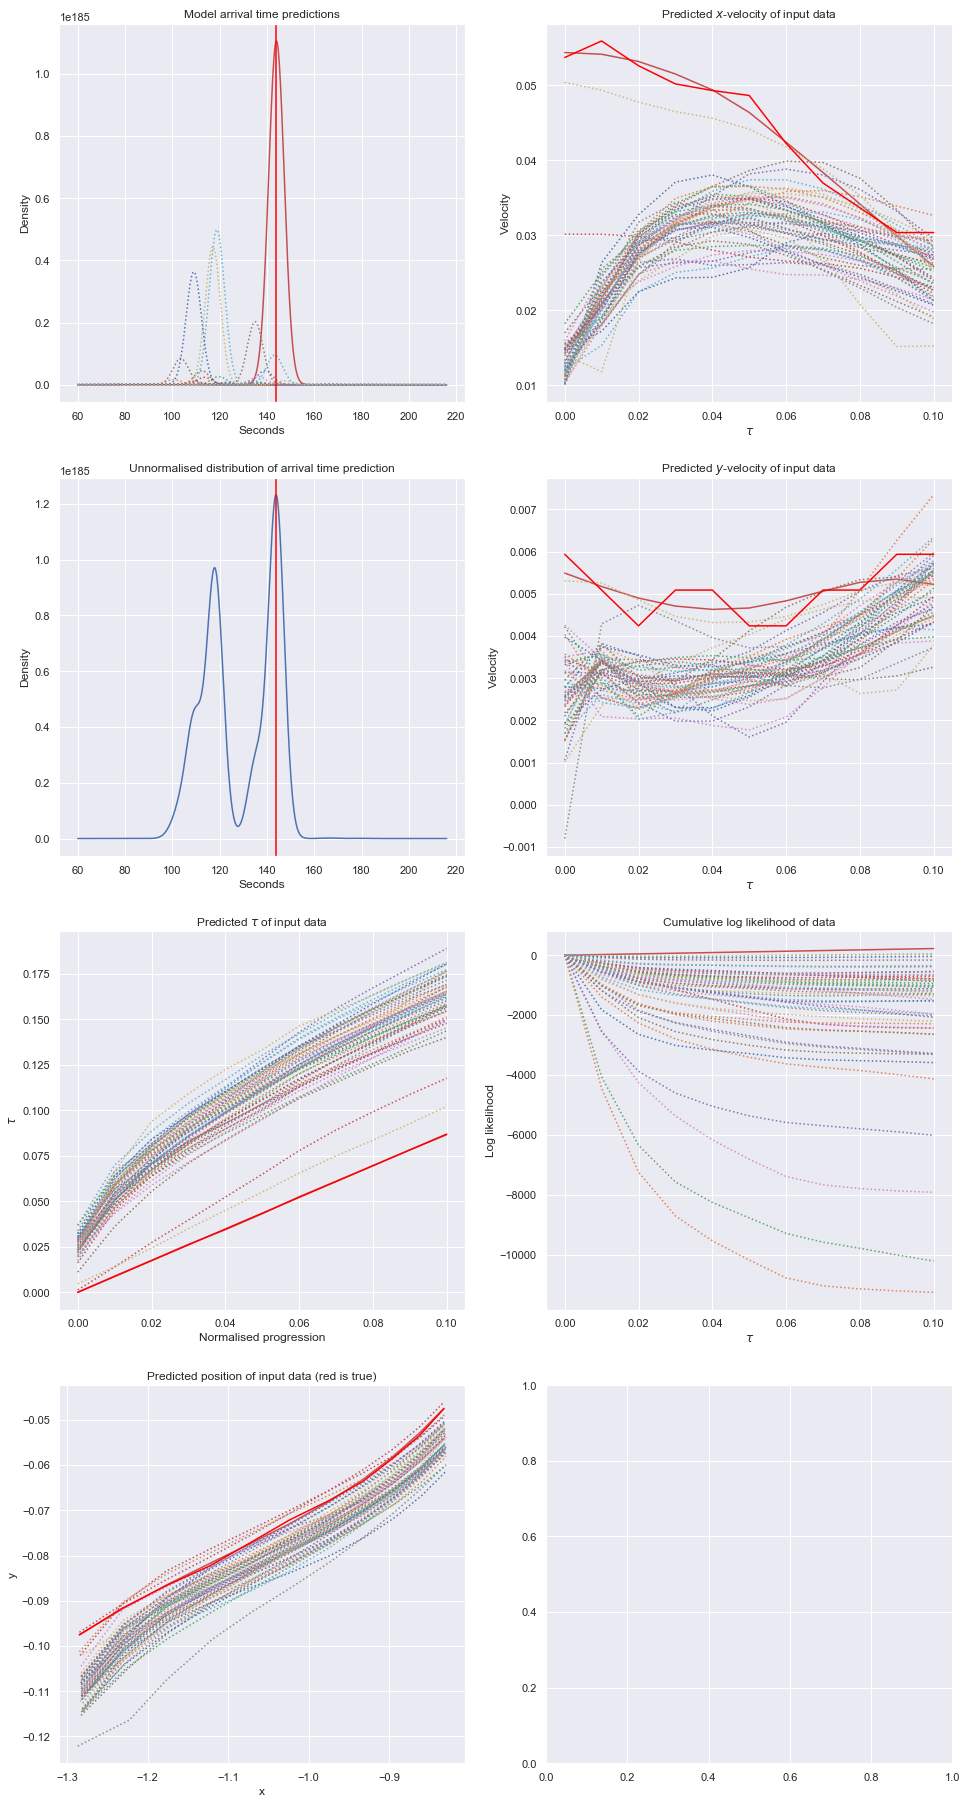

In [69]:
from functools import reduce
from scipy.stats import norm
from collections import defaultdict
from numpy.linalg import inv, det
import math
from plotting import plot_grid

def model_cum_loglik(model: TrajectoryModel, X_obs: ndarray, tau: ndarray):
    pos = X_obs[:,0:2]
    inc_tau, inc_X_obs = zip(*[
        (tau[:n], X_obs[:n]) 
        for n in range(len(tau))
    ])
    model_logliks = np.array([
        model_loglik(model, obs, tau) 
        for tau, obs in zip(inc_tau, inc_X_obs)
    ]).reshape(len(inc_tau), -1)
    
    #if any([(math.isnan(l) or math.isinf(l)) for l in model_logliks]):
        #plt.plot(range(len(model_logliks)), model_logliks)
        
    return model_logliks
    
def model_pred(model: TrajectoryModel, tau: ndarray):
    # predict for the last point
    last_point = tau[-1].reshape(1, 1)
    return predict(model.h, last_point)
    
def model_loglik(model: TrajectoryModel, X_obs: ndarray, tau: ndarray):
    """Returns the model prediction for the remaining arrival time
    together with the summed log likelihood of the data for the provided model.
    """
    #def loglik(x: ndarray, mu: ndarray, sigma: ndarray):
    #    return -0.5*((x-mu).T).dot(inv(sigma)).dot(x-mu) \
    #            -0.5*np.log(det(sigma))

    #X_k_p_x, sigma_p_x = predict(model.f_p_x, tau)
    #X_k_p_y, sigma_p_y = predict(model.f_p_y, tau)
    #X_k_v_x, sigma_v_x = predict(model.f_v_x, tau)
    #X_k_v_y, sigma_v_y = predict(model.f_v_y, tau)
    #, X_k_p_x, np.diag(sigma_p_x.T[0])))
    #print(loglik_pos_x)
    #loglik(pos[:,0].reshape(-1, 1), X_k_p_x, np.diag(sigma_p_x.T[0]))
    #loglik(pos[:,1].reshape(-1, 1), X_k_p_y, np.diag(sigma_p_y.T[0]))
    #loglik(vel[:,0].reshape(-1, 1), X_k_v_x, np.diag(sigma_v_x.T[0]))
    #loglik(vel[:,1].reshape(-1, 1), X_k_v_y, np.diag(sigma_v_y.T[0])) 
    
    pos = X_obs[:,0:2]
    vel = X_obs[:,2:4]
    loglik_pos_x = np.sum(model.f_p_x.model.log_predictive_density(tau, pos[:,0].reshape(-1, 1))) 
    loglik_pos_y = np.sum(model.f_p_y.model.log_predictive_density(tau, pos[:,1].reshape(-1, 1))) 
    loglik_vel_x = np.sum(model.f_v_x.model.log_predictive_density(tau, vel[:,0].reshape(-1, 1))) 
    loglik_vel_y = np.sum(model.f_v_y.model.log_predictive_density(tau, vel[:,1].reshape(-1, 1))) 
    loglik_sum = \
        loglik_pos_x + \
        loglik_pos_y + \
        loglik_vel_x + \
        loglik_vel_y
    
    if math.isinf(loglik_sum) or math.isnan(loglik_sum):
        print('inf loglik')
        mu = X_k_v_x
        x = vel[:,0].reshape(-1, 1)
        sigma = np.diag(sigma_v_x.T[0])
        #print(np.hstack([x, mu]))
        term1 = -0.5*((x-mu).T).dot(inv(sigma)).dot(x-mu)
        term2 = - 0.5*np.log(det(sigma))
        print('term 1', term1)
        print('term 2', term2, 'det', np.diag(sigma).T)
        print('tota',  term1 + term2)
        print('velocities', loglik_vel_x, loglik_vel_y)
        _, ax = plot_grid(1, 1)
        plot_function(model.f_v_x, ax=ax)
        ax.plot(tau, vel[:,0])

    return loglik_sum

def arrival_time_distribution(models, f_codomain, data):
        
    def make_mixture(
        grid_res: int,
        grid_pad: int,
        preds: ndarray,
        logliks: ndarray) -> ndarray:
    
        def make_distribution(
            xx: ndarray, 
            pred: ndarray, 
            loglik: float) -> ndarray:
            mean = pred[0]
            var = pred[1]
            dist = loglik*norm.pdf(xx, mean, np.sqrt(var))[0] 
            
            if (any([math.isinf(d) for d in dist])):
                print('inf in distribution for', data.iloc[0].seg)
                #print(dist, loglik)
                
            return dist
        
        # Create grid that covers all components
        asc_preds = sorted(preds)
        smallest_pred_mean = float(asc_preds[0][0])
        smallest_pred_var = float(asc_preds[0][1])
        xmin = max(0, np.floor(smallest_pred_mean - smallest_pred_var*grid_pad))
        biggest_pred_mean = float(asc_preds[-1][0])
        biggest_pred_var = float(asc_preds[-1][1])
        xmax = np.ceil(biggest_pred_mean + biggest_pred_var*grid_pad)
        xx = np.linspace(xmin, xmax, (xmax-xmin)*grid_res)
            
        distributions = [
            make_distribution(xx, p, l) 
            for p, l in zip(preds, logliks) 
        ]
            
        return distributions, xx
        
    X_obs = data[f_codomain].values
    pos = X_obs[:,0:2]
    taus, _ = zip(*[
        predict(m.g, pos)
        for m in models
    ])

    preds, logliks = zip(*[
        (model_pred(m, tau), model_loglik(m, X_obs, tau))
        for m, tau in zip(models, taus)
    ])
    
    # Scale to avoid numerical errors due to small numbers
    c = 1/max(logliks)
    loglik_sum = sum(logliks)
    #print('logliks', logliks, 'max logliks', max(logliks), 'c', c, 'loglik sum', loglik_sum)
    #print('c*logliksum', c*loglik_sum)
    #print(np.array([c*l - c*loglik_sum for l in logliks]).reshape(len(logliks), 1))
    norm_liks = np.array([np.exp(c*l - c*loglik_sum) for l in logliks]).reshape(len(logliks), 1)
    grid_res = 100
    grid_pad = 3
    #print(norm_liks)
    return make_mixture(
        grid_res, grid_pad, preds, norm_liks
    )


def plot_mixture(ax, xx, distributions, time_left):
    for i, dist in enumerate(distributions):
        linestyle = '-' if i == test_traj_ix else ':'
        ax.plot(
            xx, dist.reshape(xx.shape), 
            label='Trajectory ' + str(i),
            linestyle=linestyle
        )

    ax.set_title('Model arrival time predictions')
    ax.set_xlabel('Seconds')
    ax.set_ylabel('Density')
    ax.axvline(x=time_left, color='red', label='True arrival time')
    #ax.legend()

    
def plot_mixture_sum(ax, xx, distribution, time_left):
    ax.plot(xx, distribution)
    ax.set_title('Unnormalised distribution of arrival time prediction')
    ax.set_xlabel('Seconds')
    ax.set_ylabel('Density')
    ax.axvline(x=time_left, color='red', label='True arrival time')
    #ax.legend()
    
    
def plot_results(models, distributions, xx, seg, time_left, fraction_observed):
    n_rows = 4
    n_cols = 2
    _fig, axs = plot_grid(n_rows, n_cols)
    mixture_ax = axs[0][0]
    dist_sum_ax = axs[1][0]
    tau_pred_ax = axs[2][0]
    pos_pred_ax = axs[3][0]
    vel_x_pred_ax = axs[0][1]
    vel_y_pred_ax = axs[1][1]
    cum_tau_pred_ax = axs[2][1]
    
    plot_mixture(mixture_ax, xx, distributions, time_left)
    dist_sum = reduce(np.add, distributions).reshape(xx.shape[0])
    plot_mixture_sum(dist_sum_ax, xx, dist_sum, time_left)
    
    xx = np.linspace(0, fraction_observed, seg.shape[0])
    for i, m in enumerate(models):
        linestyle = '-' if i == test_traj_ix else ':'
        tau, _  = predict(m.g, seg[f_codomain].values)

        # Plot tau
        tau_pred_ax.plot(
            xx, tau.T[0], 
            label='Trajectory ' + str(i),
            linestyle=linestyle
        )

        # Plot position
        p_x, _ = predict(m.f_p_x, tau)
        p_y, _ = predict(m.f_p_y, tau)
        pos_pred_ax.plot(
            p_x, p_y, 
            label='Trajectory ' + str(i),
            linestyle=linestyle
        )
        
        # Plot velocity x
        v_x, _ = predict(m.f_v_x, tau)
        vel_x_pred_ax.plot(
            xx, v_x,
            label='Trajectory ' + str(i),
            linestyle=linestyle
        )

        # Plot velocity y
        v_y, _ = predict(m.f_v_y, tau)
        vel_y_pred_ax.plot(
            xx, v_y,
            label='Trajectory ' + str(i),
            linestyle=linestyle
        )

        # Plot cumulative log likelihood
        cum_tau_pred_ax.set_title(r'Cumulative log likelihood of data')
        cum_tau_pred_ax.set_xlabel(r'$\tau$')
        cum_tau_pred_ax.set_ylabel('Log likelihood')
        cum_tau_pred_ax.plot(
            xx, model_cum_logliks[i],
            label='Trajectory ' + str(i),
            linestyle=linestyle
        )
        
    tau_pred_ax.set_title(r'Predicted $\tau$ of input data')
    tau_pred_ax.set_xlabel('Normalised progression')
    tau_pred_ax.set_ylabel(r'$\tau$')
    tau_pred_ax.plot(
        xx, seg.tau,
        label='True trajectory',
        color='red'
    )
    #tau_pred_ax.legend()
    
    pos_pred_ax.set_title(r'Predicted position of input data (red is true)')
    pos_pred_ax.set_xlabel('x')
    pos_pred_ax.set_ylabel('y')
    pos_pred_ax.plot(
        seg.x, seg.y,
        label='True trajectory',
        color='red'
    )
    #pos_pred_ax.legend()
    
    vel_x_pred_ax.set_title(r'Predicted $x$-velocity of input data')
    vel_x_pred_ax.set_xlabel(r'$\tau$')
    vel_x_pred_ax.set_ylabel('Velocity')
    vel_x_pred_ax.plot(
        xx, seg.dx,
        label='True trajectory',
        color='red'
    )
    #vel_x_pred_ax.legend()
    
    vel_y_pred_ax.set_title(r'Predicted $y$-velocity of input data')
    vel_y_pred_ax.set_xlabel(r'$\tau$')
    vel_y_pred_ax.set_ylabel('Velocity')
    vel_y_pred_ax.plot(
        xx, seg.dy,
        label='True trajectory',
        color='red'
    )
    #vel_y_pred_ax.legend()
    
    plt.show()

models_to_use = models
# Test on previously seen segment
test_traj_ix = 3
test_traj_id = traj_ns[test_traj_ix]
print('predicting for', test_traj_id)
fraction_observed = .1
seg = pre_process(
    load_seg(test_traj_id, seg_n), 
    stop_compress_delta, 
    fraction_observed
)

time_left = seg.iloc[-1].time_left
f_codomain = ['x', 'y', 'dx', 'dy']
distributions, xx = arrival_time_distribution(
    models_to_use, f_codomain, seg
)
X_obs = seg[f_codomain].values
pos = X_obs[:,0:2]
model_cum_logliks = [
    model_cum_loglik(m, X_obs, predict(m.g, pos)[0])
    for m in models_to_use
]
#print(model_cum_logliks)
plot_results(
    models_to_use, distributions, xx, 
    seg, time_left, fraction_observed
)

# Performance

In [65]:
from itertools import product
import numpy as np
from sklearn.linear_model import LinearRegression

def take_fraction(data, frac):
    r = int(data.shape[0]*frac)
    return data.head(r)

def compute_errors(pred, truth):
    abs_diff = np.abs(truth-pred)
    mae = abs_diff
    mape =  abs_diff / truth
    return mae, mape

def model_prediction(models, seg):
    dists, xx = arrival_time_distribution(
        models, f_codomain, seg
    )
    dist = reduce(np.add, dists).reshape(xx.shape[0])
    #plt.plot(xx, dist)
    #dist = dist / dist_sum
    #print(np.sum(dist * xx), dist_sum)
    pred = np.sum(dist * xx) / np.sum(dist) # mean
    #pred = xx[np.argmax(dist)] #mode
    #if math.isnan(pred):
    #    print('dists are nan for ', seg_size, test_seg_n)
        #print(dists)
    return pred

    #models_avg_mae = [np.sum(list(mae[s].values())) / len(mae[s].values()) for s in seg_sizes]
    #models_avg_mape = [np.sum(list(mape[s].values())) / len(mape[s].values()) for s in seg_sizes]
    #return models_avg_mae, models_avg_mape
    
def mean_prediction(seg):
    X = seg.tau.values.reshape(-1, 1)
    y = seg.time_left.values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    x_star = seg.iloc[-1].tau.reshape(-1, 1)
    return reg.predict(x_star)

def average_performance(performance, model):
    seg_sizes = list(performance.keys())
    seg_ns = list(performance[seg_sizes[0]].keys())
    return [np.sum([performance[seg_size][seg_n][model] for seg_n in seg_ns]) 
        for seg_size in seg_sizes
    ]
        
def evaluate(models, test_segs, seg_sizes):
    maes  = {s: defaultdict(dict) for s in seg_sizes}
    mapes = {s: defaultdict(dict) for s in seg_sizes}
    #mean_maes = {s: defaultdict(dict) for s in seg_sizes} #[np.sum(list(mean_mape[s].values())) / len(mean_mape[s].values()) for s in seg_sizes]
    #mean_mapes = {s: defaultdict(dict) for s in seg_sizes} #[np.sum(list(mean_mae[s].values())) / len(mean_mae[s].values()) for s in seg_sizes]
    for i, test_seg_n in enumerate(test_segs.keys()):
        for seg_size in seg_sizes:
            maes[seg_size][test_seg_n] = defaultdict(dict)
            mapes[seg_size][test_seg_n] = defaultdict(dict)
            
            seg = take_fraction(test_segs[test_seg_n], seg_size)
            time_left = seg.iloc[-1].time_left
            
            # Model performance
            model_pred = model_prediction(models, seg)
            model_mae, model_mape = compute_errors(model_pred, time_left)
            maes[seg_size][test_seg_n]['model'] = model_mae
            mapes[seg_size][test_seg_n]['model'] = model_mape
            
            # Mean prediction performance
            mean_pred = mean_prediction(seg)
            mean_mae, mean_mape = compute_errors(mean_pred, time_left)
            maes[seg_size][test_seg_n]['mean'] = mean_mae
            mapes[seg_size][test_seg_n]['mean'] = mean_mape
            
        #clear_output()
        print('Done seg', i, 'of', len(test_segs))
  
    model_avg_mae = average_performance(maes, 'model')
    model_avg_mape = average_performance(mapes, 'model')
    mean_avg_mae = average_performance(maes, 'mean')
    mean_avg_mape = average_performance(mapes, 'mean')
    
    fig, ax = plot_grid(1, 2)
    mae_ax = ax[0]
    mape_ax = ax[1]
    mae_ax.plot(seg_sizes, model_avg_mae, label='Model avg MAE')
    mae_ax.plot(seg_sizes, mean_avg_mae, label='Mean pred. avg MAE')
    mae_ax.set_title('Average MAE')
    mae_ax.set_ylabel('MAE')
    mae_ax.set_xlabel('Amount of trajectory observed')

    #for xy in zip(seg_sizes, model_avg_mae):                                       
    #    mae_ax.annotate('%s' % xy[1], xy=xy, textcoords='data') 
        
    mae_ax.legend()
    
    mape_ax.set_title('Average MAPE')
    mape_ax.set_ylabel('MAPE')
    mape_ax.set_xlabel('Amount of trajectory observed')
    mape_ax.plot(seg_sizes, model_avg_mape, label='Model avg MAPE')
    mape_ax.plot(seg_sizes, mean_avg_mape, label='Mean pred. avg MAPE')
    
    #for xy in zip(seg_sizes, model_avg_mape):                                       
    #    mape_ax.annotate('%s' % xy[1], xy=xy, textcoords='data') 
        
    mape_ax.legend()

## In Sample 

Done seg 0 of 2
Done seg 1 of 2


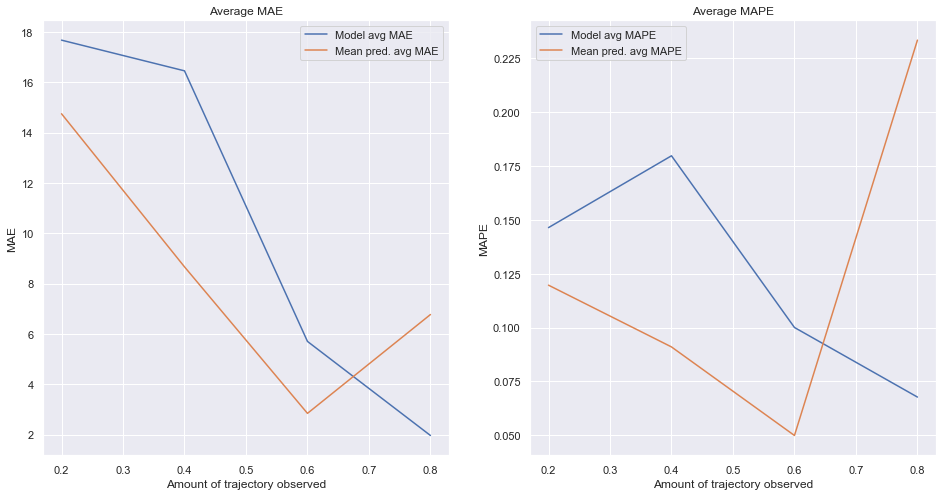

In [66]:
from IPython.display import display, clear_output
import math

np.random.seed(1)
#segs = dict(tuple(data[data.seg = seg_n].groupby('seg')))

test_segs = {
    traj_n: pre_process(load_seg(traj_n, seg_n), stop_compress_delta)
    for traj_n in traj_ns[:2]
}
seg_sizes = [.2, .4, .6, .8]

evaluate(models_to_use, test_segs, seg_sizes)

Done seg 0 of 100
Done seg 1 of 100
Done seg 2 of 100
Done seg 3 of 100
Done seg 4 of 100
Done seg 5 of 100
Done seg 6 of 100
Done seg 7 of 100
Done seg 8 of 100
Done seg 9 of 100
Done seg 10 of 100
Done seg 11 of 100
Done seg 12 of 100
Done seg 13 of 100
Done seg 14 of 100
Done seg 15 of 100
Done seg 16 of 100
Done seg 17 of 100
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning:invalid value encountered in double_scalars


[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning:invalid value encountered in double_scalars


[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning:invalid value encountered in double_scalars


[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning:invalid value encountered in multiply


Done seg 19 of 100
Done seg 20 of 100
Done seg 21 of 100
Done seg 22 of 100
Done seg 23 of 100
Done seg 24 of 100
Done seg 25 of 100
Done seg 26 of 100
Done seg 27 of 100
Done seg 28 of 100
Done seg 29 of 100
Done seg 30 of 100
Done seg 31 of 100
Done seg 32 of 100
Done seg 33 of 100
Done seg 34 of 100
Done seg 35 of 100
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf]

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning:invalid value encountered in double_scalars
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning:overflow encountered in reduce
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning:invalid value encountered in double_scalars


Done seg 36 of 100
Done seg 37 of 100
Done seg 38 of 100
Done seg 39 of 100
Done seg 40 of 100
Done seg 41 of 100
Done seg 42 of 100
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[in

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning:invalid value encountered in double_scalars


[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf] [inf]
[inf inf inf ... inf inf inf

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning:invalid value encountered in double_scalars


Done seg 43 of 100
Done seg 44 of 100
Done seg 45 of 100
Done seg 46 of 100
Done seg 47 of 100
Done seg 48 of 100
Done seg 49 of 100
Done seg 50 of 100
Done seg 51 of 100
Done seg 52 of 100
Done seg 53 of 100
Done seg 54 of 100
Done seg 55 of 100
Done seg 56 of 100
Done seg 57 of 100
Done seg 58 of 100
Done seg 59 of 100
Done seg 60 of 100
Done seg 61 of 100
Done seg 62 of 100
Done seg 63 of 100
Done seg 64 of 100
Done seg 65 of 100
Done seg 66 of 100
Done seg 67 of 100
Done seg 68 of 100
Done seg 69 of 100
Done seg 70 of 100
Done seg 71 of 100
Done seg 72 of 100
Done seg 73 of 100
Done seg 74 of 100
Done seg 75 of 100
Done seg 76 of 100
Done seg 77 of 100
Done seg 78 of 100
Done seg 79 of 100
Done seg 80 of 100
Done seg 81 of 100
Done seg 82 of 100
Done seg 83 of 100
Done seg 84 of 100
Done seg 85 of 100
Done seg 86 of 100
Done seg 87 of 100
Done seg 88 of 100
Done seg 89 of 100
Done seg 90 of 100


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning:invalid value encountered in double_scalars


Done seg 91 of 100
Done seg 92 of 100
Done seg 93 of 100
Done seg 94 of 100
Done seg 95 of 100
Done seg 96 of 100
Done seg 97 of 100
Done seg 98 of 100
Done seg 99 of 100


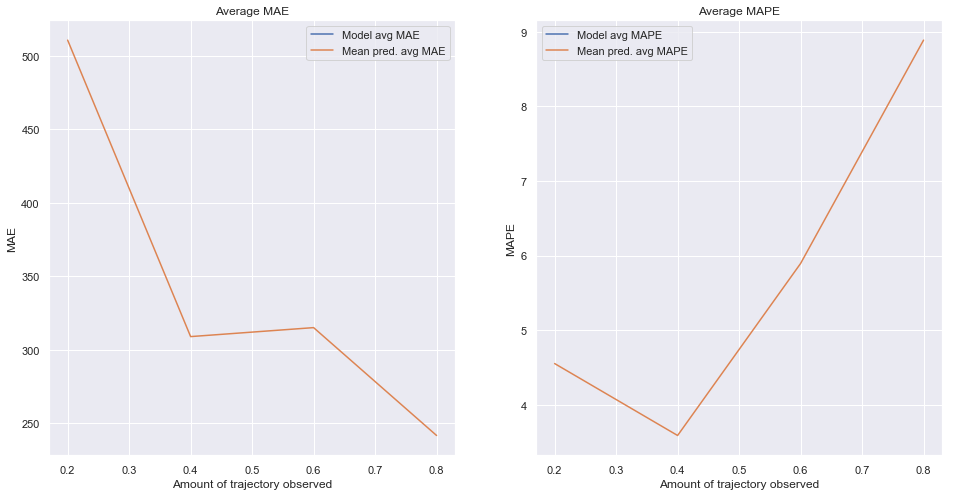

In [67]:
loaded = False
if loaded is False:
    test_trajs_pickle_path = '../data/test3.pkl'
    test_data = pd.read_pickle(test_trajs_pickle_path)
    n_test_trajs = list(test_data.traj.unique())
    n_test_trajs_to_use = 100 #len(n_trajs)
    test_trajs_to_use = frozenset(np.random.choice(n_test_trajs, size=n_test_trajs_to_use, replace=False))
    test_trajs = test_data[test_data.traj.transform(lambda j: j in test_trajs_to_use)]
    test_traj_ns = test_trajs.traj.unique()
    loaded=True

def load_test_seg(traj_n, seg_n):
    return test_trajs[(test_trajs.traj == traj_n) & (test_trajs.seg == seg_n)]

#fig, ax = plot_grid(1, 1)
out_of_sample_test_segs = {
    traj_n: pre_process(load_test_seg(traj_n, seg_n), stop_compress_delta)
    for traj_n in test_traj_ns
}

evaluate(models_to_use, out_of_sample_test_segs, seg_sizes)

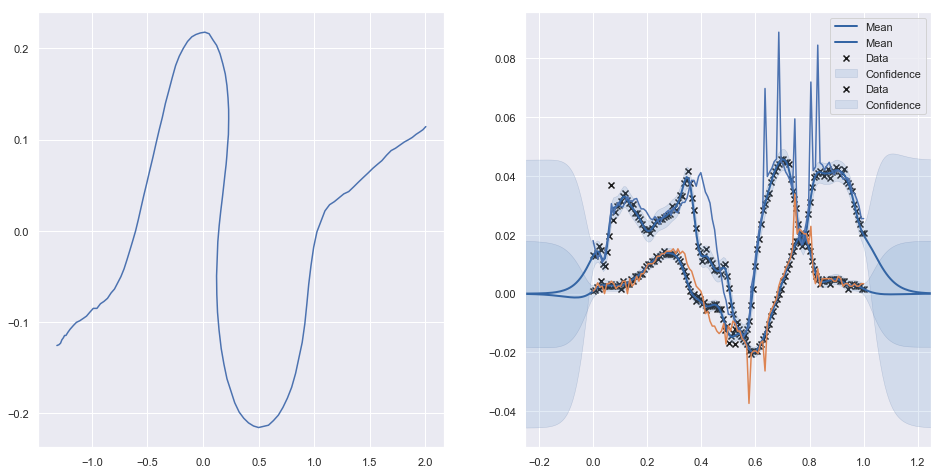

In [159]:
broken_seg_id = 461
broken_seg = test_trajs[(test_trajs.traj == brokken_seg_id) & (test_trajs.seg == seg_n)]
broken_seg = pre_process(broken_seg, stop_compress_delta)
_, ax = plot_grid(1, 2)
ax[0].plot(broken_seg.x, broken_seg.y)
plot_function(models_to_use[0].f_v_x, ax=ax[1])
plot_function(models_to_use[0].f_v_y, ax=ax[1])
ax[1].plot(broken_seg.tau, broken_seg.dx)
ax[1].plot(broken_seg.tau, broken_seg.dy)